# Xopt Evaluator Basic Usage 

In [1]:
# needed for macos
import platform

if platform.system() == "Darwin":
    import multiprocessing as mp

    mp.set_start_method("fork")

In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.evaluator import DummyExecutor
import numpy as np
import pandas as pd
from time import sleep
from random import randint

In [3]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})


def f(inputs):

    sleep(randint(1, 5))  # simulate computation time
    # Make some occasional errors
    if inputs["x"] > 0.8:
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}


in1 = vocs.random_inputs()

try:
    f(in1)
except Exception as ex:
    print(f"Caught error in f: {ex}")

In [4]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
1,0.822082,0.895109
2,0.000877,0.245277
3,0.267191,0.801480
4,0.852858,0.866663


In [5]:
# Internal futures dictionary
X._futures

{1: <Future at 0x16ad0bd60 state=finished raised ValueError>,
 2: <Future at 0x107f52af0 state=finished returned dict>,
 3: <Future at 0x107f10520 state=finished returned dict>,
 4: <Future at 0x107f19d90 state=finished raised ValueError>}

In [6]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,xopt_error,xopt_error_str,f1
1,0.822082,0.895109,True,"Traceback (most recent call last):\n File ""/U...",NaN
2,0.000877,0.245277,False,,0.060162
3,0.267191,0.801480,False,,0.713761
4,0.852858,0.866663,True,"Traceback (most recent call last):\n File ""/U...",NaN


In [7]:
# Futures are now cleared out
X._futures

{}

In [8]:
# This is the internal counter
X._ix_last

4

In [9]:
X.submit_data(vocs.random_inputs(4))
X._input_data

,x,y
5,0.393575,0.853055
6,0.447761,0.543316
7,0.419078,0.422410
8,0.023418,0.896143


In [10]:
X._futures

{5: <Future at 0x16ad83c10 state=finished returned dict>,
 6: <Future at 0x10800d460 state=finished returned dict>,
 7: <Future at 0x107f108e0 state=finished returned dict>,
 8: <Future at 0x16ad0bd30 state=finished returned dict>}

In [11]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,xopt_error,xopt_error_str,f1
1,0.822082,0.895109,True,"Traceback (most recent call last):\n File ""/U...",NaN
2,0.000877,0.245277,False,,0.060162
3,0.267191,0.801480,False,,0.713761
4,0.852858,0.866663,True,"Traceback (most recent call last):\n File ""/U...",NaN
5,0.393575,0.853055,False,,0.882604
6,0.447761,0.543316,False,,0.495683
7,0.419078,0.422410,False,,0.354056
8,0.023418,0.896143,False,,0.803621
9,0.241190,0.924014,False,,0.911975


# Executors

In [12]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [13]:
MAX_WORKERS = 10

In [14]:
# Dask
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [15]:
executor = "ThreadPoolExecutor"
# executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

'ThreadPoolExecutor'

In [16]:
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [17]:
for _ in range(20):
    X2.step()

<AxesSubplot:xlabel='x', ylabel='y'>

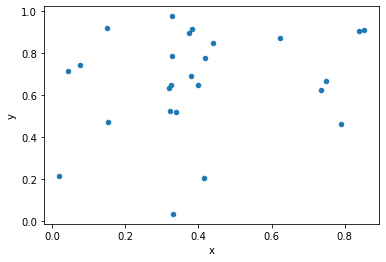

In [18]:
X2.data.plot.scatter("x", "y")

In [19]:
X2.data

,x,y,f1,xopt_error,xopt_error_str
4,0.153792,0.471685,0.246139,False,
6,0.440836,0.846209,0.910407,False,
8,0.043175,0.713456,0.510884,False,
2,0.319932,0.633224,0.503329,False,
1,0.399532,0.646312,0.577345,False,
9,0.375793,0.894418,0.941204,False,
10,0.326634,0.644966,0.522672,False,
13,0.321575,0.521316,0.375181,False,
12,0.326907,0.974416,1.056355,False,
3,0.076974,0.741016,0.555030,False,
